<a href="https://colab.research.google.com/gist/ACrousi/6dec1a3e3d52c46a87b98c7b791572cf/spinedetection3_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境模組安裝

In [ ]:
# !pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
!pip install git+https://github.com/facebookresearch/detectron2.git
!pip install funcy
!git clone https://github.com/akarazniewicz/cocosplit.git

from detectron2.utils.logger import setup_logger
setup_logger()

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-zsk9pfxf
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-zsk9pfxf
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 74 kB 1.7 MB/s 
     |████████████████████████████████| 145 kB 77.3 MB/s 
     |████████████████████████████████| 130 kB 69.1 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 749 kB 59.0 MB/s 
     |████████████████████████████████| 843 kB 61.7 MB/s 
     |████████████████████████████████| 596 kB 70.8 MB/s 
     |████████████████████████████████| 112 kB 74.8 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5713093 sha256=b7d2581fd53688291720861db736b2b00ed7b804e1323e3f65b580814ffe1cea
  Stored in directory: /tmp/pip-ephem-wheel-cache-n3i3rqj7/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7

Cloning into 'cocosplit'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 17 (delta 3), reused 3 (delta 3), pack-reused 11
Unpacking objects: 100% (17/17), done.


<Logger detectron2 (DEBUG)>

# 連接雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 路徑參數設定

In [ ]:
cloud_path = '/content/drive/My Drive/407_SpineDetection'
zip_path = cloud_path + '/spine_dataset.zip'
to_path = '/_temp'
ann_file = to_path+'/spine_ann.json'
diagnosis_file = to_path+"/diagnosis.csv"

### 解壓縮

In [ ]:
from zipfile import ZipFile

!rm -rf "/_temp"

def unzip(paths, to_path):
  """paths: list, to_path"""
  for path in paths:
    if path.endswith('.zip'):
      with ZipFile(path, 'r') as zipObj:
        zipObj.extractall(to_path)
        childs = ['{}/{}'.format(to_path, file_name) for file_name in zipObj.namelist()]
        unzip(childs, to_path)

# unzip([zip_path], to_path)

In [ ]:
import os

%cd cocosplit/
!python cocosplit.py -s 0.8 '/_temp/spine_ann.json' '/_temp/annotations/train.json' '/_temp/annotations/val.json'
train_path = to_path + '/train/'
val_path = train_path
test_path = to_path + '/test/'
train_ann = to_path + '/annotations/train.json'
val_ann = to_path + '/annotations/val.json'
test_ann = to_path + '/annotations/test.json'

/content/cocosplit
Traceback (most recent call last):
  File "cocosplit.py", line 52, in <module>
    main(args)
  File "cocosplit.py", line 28, in main
    with open(args.annotations, 'rt', encoding='UTF-8') as annotations:
FileNotFoundError: [Errno 2] No such file or directory: '/_temp/spine_ann.json'


# 建立診斷資料集

###IMAGE + TABULER 模型訓練

###解壓縮

In [ ]:
!rm -rf "/_temp"

In [ ]:
zip_path = cloud_path + '/spine_multiclass.zip'

unzip([zip_path], to_path)

###DataSet 宣告

In [ ]:
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch
import numpy as np

class cusDataset(Dataset):
    def __init__(self, root, csv, transform):
        ##############################################
        ### Initialize paths, transforms, and so on
        ### data list -> DataFrame ID, Label
        ##############################################
        self.transform = transform
        self.df = pd.read_csv(csv)
        self.col = ["L1L2","L2L3","L3L4", "L4L5", "L5S1"]
        # 
        # load image path and annotations
        self.imgs = self.df["file_name"].tolist()                     #filename list
        self.imgs = [ '{}/{}'.format(root, img) for img in self.imgs ]
        # self.annotations = self.df.loc[:,self.col].copy().values.astype(np.float32)    #annotation list
        self.lbls = self.df.loc[:,self.col].copy().to_numpy()                   #label list
        assert len(self.imgs) == len(self.lbls), 'mismatched length!'
        print ('Total data split: {}'.format(len(self.imgs)))
        
    def __getitem__(self, index):
        ##############################################
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        ##############################################
        imgpath = self.imgs[index]
        img = Image.open(imgpath).convert('RGB')
        # size = img.size
        (w,h) = img.size
        img = img.resize((int(w*0.15),int(h*0.15)))
        lbl = torch.FloatTensor(self.lbls[index])
        if self.transform is not None:
            img = self.transform(img)
        return {"img":img, "label":lbl}
        
    def __len__(self):
        ##############################################
        ### Indicate the total size of the dataset
        ##############################################
        return len(self.imgs)



###模型建立

In [ ]:
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import nn
import torch
import math

class SpineClassification(nn.Module):
  def __init__(self):
    super(SpineClassification, self).__init__()
    #model = models.resnet50(pretrained=True)
    self.cnn = models.efficientnet_b0(pretrained=True)
    self.output_num = [4,2,1]
    self.cnn.classifier[1]=nn.Linear(1280,5)

    
  def forward(self, image):
    x = self.cnn(image)
    return x

In [ ]:
import time
import copy
import torch
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc

def tensor_th(model_pred, labels, th=0.5):
  pred = model_pred > th
  return pred.float()

def calculate_pre_recall(pred, labels):
  precision = 0
  recall = 0
  acc = 0
  # pred = model_pred > th
  # pred = pred.float()
  precision = torch.sum(pred*labels) / torch.sum(pred)
  recall = torch.sum(pred*labels) / torch.sum(labels)
  acc = torch.sum(pred == labels) / pred.size(0)
  return precision, recall, acc

def calculate_acc(pred, labels):
  pred = pred.reshape(-1,)
  labels = labels.reshape(-1,)
  acc = torch.sum(pred == labels)/pred.size(0)
  return acc


def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25, is_inception=False, th=0.5):
    since = time.time()
    Sigmoid_fun = nn.Sigmoid()

    history = {
        'loss_val': [],
        'loss_train': [],
        'acc_val': [],
        'acc_train': [],
        'AUC_val': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_AUC = 0.0
    best_loss = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        
        for phase in ['train', 'val']:
            y_label = torch.tensor([])
            y_pred = torch.tensor([])
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # for inputs, annotation, labels in dataloaders[phase]:
            for batch_index, dataset in enumerate(dataloaders[phase]):
                inputs = dataset["img"]
                # annotation = dataset["annotation"]
                labels = dataset["label"]
                true_label = labels.clone()

                inputs = inputs.to(device)
                # annotation = annotation.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        # outputs, aux_outputs = model(inputs)
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        # outputs = model(inputs)
                        outputs = model(inputs)
                        loss = criterion(Sigmoid_fun(outputs), labels)
                        pred = Sigmoid_fun(outputs).clone().detach().cpu()
                        pred = tensor_th(pred, true_label, th)

                        # print(Sigmoid_fun(outputs), loss)
                        # loss = criterion(outputs, labels)

                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += sum(torch.sum(outputs == labels))
                # print(outputs, labels)
                # if phase == 'val':
                y_label = torch.cat((y_label,true_label), 0)
                y_pred = torch.cat((y_pred,pred), 0)

            y_pred = torch.transpose(y_pred, 0, 1)
            y_label = torch.transpose(y_label, 0, 1)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = calculate_acc(y_pred, y_label)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == "val":
              for i in range(y_pred.shape[0]):
                precision, recall, acc = calculate_pre_recall(y_pred[i], y_label[i])
                print("{}: precision: {} recall: {} acc: {}".format(i, precision, recall, acc))
                print(confusion_matrix(y_label[i], y_pred[i]))
            
            # epoch_acc = running_corrects.double() / (len(dataloaders[phase].dataset) * inputs.size(0))
            # if phase == 'val':
              # fpr, tpr, threshold = roc_curve(y_label, y_pred)
              # epoch_auc_score = auc(fpr, tpr)
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # if phase == 'val':
              # print('AUC:',epoch_auc_score)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
              best_loss = epoch_loss
              best_acc = epoch_acc
              best_epoch = epoch
              best_model_wts = copy.deepcopy(model.state_dict())
            # if phase == 'val' and epoch_auc_score > best_AUC:
                # best_acc = epoch_acc
                # best_AUC = epoch_auc_score
                # best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                history['acc_val'].append(epoch_acc)
                history['loss_val'].append(epoch_loss)
                # history['AUC_val'].append(epoch_auc_score)
            else:
                history['acc_train'].append(epoch_acc)
                history['loss_train'].append(epoch_loss)
        #confusion matrix

        # for j in range(y_true.size[0]):
        #   cnf_matrix = confusion_matrix(y_label[j], y_pred[j])
        #   print(j+":")
        #   print(cnf_matrix)
        if scheduler is not None:
          scheduler.step()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} Best val AUC: {:4f}'.format(best_acc, best_AUC))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

###HyperParameter設定

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
# Models to choose from [resnet50, resnet152, alexnet, vgg, squeezenet, densenet, inception]
model_name = "efficientnet_b0"

# Number of classes in the dataset
# num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 200

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
# True = 僅對最後一層 FCLayer 參數調整
# False = 調整整個預訓練模型參數
feature_extract = False


name_optimizer = "Adam"    #(記錄用)

# learning rate
learning_rate = 0.0001

# momentum (SGD)
momentum = 0.9

input_size = 224

###資料擴增設定

In [ ]:
data_transforms = {
    'train': transforms.Compose([
                # transforms.RandomVerticalFlip(),
                # transforms.RandomHorizontalFlip(),
                # transforms.Resize((256, 256)),
                # transforms.RandomApply([
                transforms.RandomAffine(degrees=(0,0), translate=(0.1,0.05), scale=(1,1.1)),                
                # ], p=0.5),
                # transforms.RandomCrop((input_size, input_size)),
                # transforms.Resize(0.7),
                transforms.CenterCrop((450, 300)),
                transforms.Grayscale(3),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.3661, 0.3661, 0.3661], std=[0.2168, 0.2168, 0.2168]),           
                # transforms.Normalize(mean=[0.2937, 0.2937, 0.2937], std=[0.2382, 0.2382, 0.2382]),
                ]),
    'val': transforms.Compose([
                    # transforms.Resize(0.7),
                    transforms.CenterCrop((450, 300)),
                    transforms.Grayscale(3),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.3661, 0.3661, 0.3661], std=[0.2168, 0.2168, 0.2168]),
                    # transforms.Normalize(mean=[0.2937, 0.2937, 0.2937],
                    #                std=[0.2382, 0.2382, 0.2382]),
                    ])
}

###資料集宣告

In [ ]:
import pandas as pd

train_img_dir = to_path + "/datasets"
val_img_dir = train_img_dir

dig_train_f = to_path + "/train.csv"
dig_val_f = to_path + "/val.csv"

trainset = cusDataset(root=train_img_dir, csv=dig_train_f, transform=data_transforms['train'])
valset = cusDataset(root=val_img_dir, csv=dig_val_f, transform=data_transforms['val'])

train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers=2)

Total data split: 392
Total data split: 98


###圖片預覽

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(trainset.__getitem__(5)["img"].permute(1, 2, 0))
print(trainset.__getitem__(71)["label"])

訓練模型優化器(Optimizer)、策略(scheduler)設定

In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model = SpineClassification()
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# 優化器策略
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,20,eta_min=0.00000001,last_epoch=-1)
print(optimizer)
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss(weight=class_weights) 

Params to learn:
	 cnn.features.0.0.weight
	 cnn.features.0.1.weight
	 cnn.features.0.1.bias
	 cnn.features.1.0.block.0.0.weight
	 cnn.features.1.0.block.0.1.weight
	 cnn.features.1.0.block.0.1.bias
	 cnn.features.1.0.block.1.fc1.weight
	 cnn.features.1.0.block.1.fc1.bias
	 cnn.features.1.0.block.1.fc2.weight
	 cnn.features.1.0.block.1.fc2.bias
	 cnn.features.1.0.block.2.0.weight
	 cnn.features.1.0.block.2.1.weight
	 cnn.features.1.0.block.2.1.bias
	 cnn.features.2.0.block.0.0.weight
	 cnn.features.2.0.block.0.1.weight
	 cnn.features.2.0.block.0.1.bias
	 cnn.features.2.0.block.1.0.weight
	 cnn.features.2.0.block.1.1.weight
	 cnn.features.2.0.block.1.1.bias
	 cnn.features.2.0.block.2.fc1.weight
	 cnn.features.2.0.block.2.fc1.bias
	 cnn.features.2.0.block.2.fc2.weight
	 cnn.features.2.0.block.2.fc2.bias
	 cnn.features.2.0.block.3.0.weight
	 cnn.features.2.0.block.3.1.weight
	 cnn.features.2.0.block.3.1.bias
	 cnn.features.2.1.block.0.0.weight
	 cnn.features.2.1.block.0.1.weight
	 cnn.fea

#模型訓練

###模型訓練

In [ ]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=num_epochs, is_inception=True if model_name == "inception" else False, th=0.5)


###儲存模型

In [ ]:
import time
import os

t = time.localtime()
# result_path = cloud_path + 'result/'
LocalSave_path = '/content/drive/My Drive/Model_Report/'
dir_path = LocalSave_path + time.strftime("%Y-%m-%d-%H-%M-%S", t)
print(time.strftime("%Y-%m-%d-%H-%M-%S", t))

if not os.path.exists(LocalSave_path):
  print('mkdir ' + LocalSave_path)
  os.mkdir(LocalSave_path)
os.makedirs(dir_path, exist_ok=True)

output_path = '{}/{}'.format(dir_path, 'SpineDetection_dg.pth')
# torch.save colab 會有 error output, 不需要理會
torch.save(model, output_path)
# torch.save(model.state_dict(), output_path)

2021-11-23-14-59-04


###Loss、ACC圖表

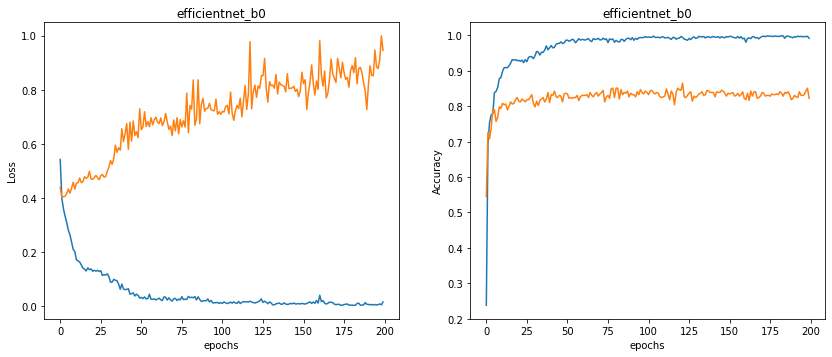

In [ ]:
import matplotlib.pyplot as plt


# plt.title(model_name)
# plt.plot(history['loss_train'], label='Training Loss')
# plt.plot(history['loss_val'], label='Validation Loss')
# # plt.plot(test_losses, label='Validation loss')
# plt.legend(frameon=False)
# plt.show()

fig = plt.figure(figsize = [14,12])
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)

def plot_curves(ax, mode='acc'):
  plt.sca(ax)
  plt.title(model_name)
  if mode == "loss":
    plt.plot(history['loss_train'], label='Training Loss')
    plt.plot(history['loss_val'], label='Validation Loss')
    plt.ylabel("Loss")
  else:
    plt.plot(history['acc_train'], label='Training Accuracy')
    plt.plot(history['acc_val'], label='Validation Accuracy')
    plt.ylabel("Accuracy")
  plt.xlabel("epochs")

plot_curves(ax1, mode='loss')
plot_curves(ax2, mode='acc')

plt.savefig('{}/{}'.format(dir_path, '{}.png'.format(time.strftime("%Y-%m-%d-%H-%M-%S", t))), format='png')

#模型測試

###匯入測試資料集

In [ ]:
import pandas as pd


test_img_dir = to_path + "/datasets"

dig_test_f = to_path + "/test.csv"


testset = cusDataset(root=test_img_dir, csv=dig_test_f, transform=data_transforms['val'])

test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=2)

Total data split: 95


###T-SNE圖表分析

In [ ]:
# load model  (T-SNE)
import torch
import torch.nn as nn
import torch.nn.functional as nnf
from PIL import Image
# import sklearn.feature_extraction as feature_extraction
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# output_path = cloud_path + '2021-11-17-14-12-17/SpineDetection_dg.pth'
model = torch.load(output_path)
# model.load_state_dict(torch.load(output_path))
model.eval()
# model = model.cnn.features


x_features = torch.tensor([])
x_features = x_features.to(device)

x_annotations = torch.tensor([])
x_annotations = x_annotations.to(device)
for batch_index, dataset in enumerate(val_loader):
  with torch.no_grad():
    inputs = dataset["img"]
    labels = dataset["label"]

    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    x_features = torch.cat((x_features,outputs), 0)
    print(x_features.shape)
x_features = x_features.reshape(x_features.shape[0],-1)
print(x_features.shape)

torch.Size([8, 5])
torch.Size([16, 5])
torch.Size([24, 5])
torch.Size([32, 5])
torch.Size([40, 5])
torch.Size([48, 5])
torch.Size([56, 5])
torch.Size([64, 5])
torch.Size([72, 5])
torch.Size([80, 5])
torch.Size([88, 5])
torch.Size([96, 5])
torch.Size([98, 5])
torch.Size([98, 5])


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import pandas as pd
x_test = x_features.tolist()
y_test = pd.read_csv(dig_val_f)["L4L5"].tolist()
X_std = StandardScaler().fit_transform(x_test) 
tsne = TSNE(n_components=2) 
X_tsne = tsne.fit_transform(X_std) 
X_tsne_data = np.vstack((X_tsne.T, y_test)).T 
df_tsne = pd.DataFrame(X_tsne_data, columns=["Dim1", "Dim2", "class"]) 
df_tsne.head()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


,Dim1,Dim2,class
0,3.228812,-0.879887,1.0
1,1.085029,-2.965627,1.0
2,5.367304,0.283558,0.0
3,2.906599,1.755295,1.0
4,2.371324,-3.562999,0.0


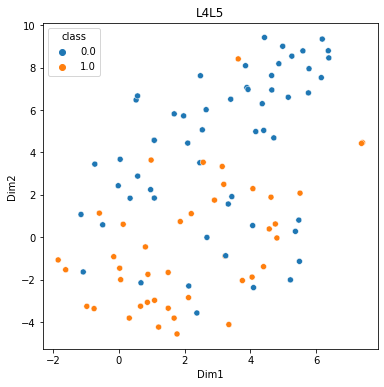

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6)) 
plt.title("L4L5")
sns.scatterplot(data=df_tsne, hue="class", x="Dim1", y="Dim2") 
plt.show()

In [ ]:
import pandas as pd


test_img_dir = to_path + "/datasets"


dig_test_f = to_path + "/test.csv"



testset = cusDataset(root=test_img_dir, csv=dig_test_f, transform=data_transforms['val'])

test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=2)

Total data split: 95


###混淆矩陣分析

In [ ]:
# load model
import torch.nn.functional as nnf
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# output_path = '/content/drive/My Drive/Model_Report/2021-11-13-05-31-28/SpineDetection_dg.pth'
model = torch.load(output_path)
# model.load_state_dict(torch.load(output_path))
model.eval()

# y_pred = []
# score = []
# y_prob = []

y_label = torch.tensor([])
y_pred = torch.tensor([])
Sigmoid_fun = nn.Sigmoid()

for batch_index, dataset in enumerate(test_loader):
  with torch.no_grad():
    inputs = dataset["img"]
    # annotation = dataset["annotation"]
    labels = dataset["label"]
    true_label = labels.clone()

    inputs = inputs.to(device)
    # annotation = annotation.to(device)
    labels = labels.to(device)
    outputs = model(inputs) 
    loss = criterion(Sigmoid_fun(outputs), labels)
    pred = Sigmoid_fun(outputs).clone().detach().cpu()
    pred = tensor_th(pred, true_label, 0.5)

    # prob = nnf.softmax(outputs, dim=1)
    # y_prob += prob.tolist()
    # _, predicted = torch.max(outputs, 1)
    # y_pred += predicted.tolist()

    y_label = torch.cat((y_label,true_label), 0)
    y_pred = torch.cat((y_pred,pred), 0)

y_pred = torch.transpose(y_pred, 0, 1)
y_label = torch.transpose(y_label, 0, 1)

acc = calculate_acc(y_pred, y_label)
print("acc: {}".format(acc))

for i in range(y_pred.shape[0]):
  precision, recall, acc = calculate_pre_recall(y_pred[i], y_label[i])
  print("{}: precision: {} recall: {} acc:{}".format(i, precision, recall, acc))
  print(confusion_matrix(y_label[i], y_pred[i]))

acc: 0.8168420791625977
0: precision: nan recall: 0.0 acc:0.9578947424888611
[[91  0]
 [ 4  0]]
1: precision: 0.5 recall: 0.125 acc:0.9157894849777222
[[86  1]
 [ 7  1]]
2: precision: 0.5 recall: 0.32258063554763794 acc:0.6736842393875122
[[54 10]
 [21 10]]
3: precision: 0.581818163394928 recall: 0.8648648858070374 acc:0.7052631378173828
[[35 23]
 [ 5 32]]
4: precision: 0.20000000298023224 recall: 0.4285714328289032 acc:0.8315789699554443
[[76 12]
 [ 4  3]]


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(ax, cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.sca(ax)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

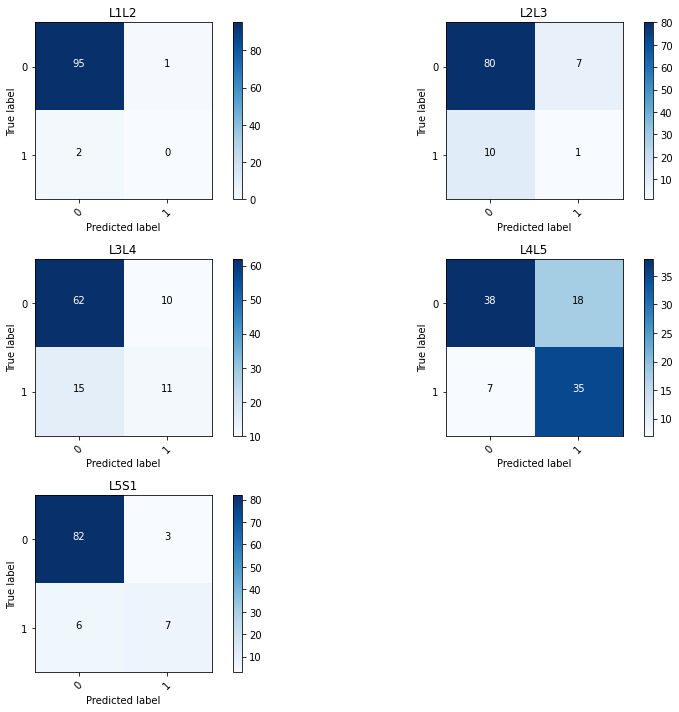

In [ ]:

fig = plt.figure(figsize = [12,10])
ax1 = plt.subplot(3,2,1)
ax2 = plt.subplot(3,2,2)
ax3 = plt.subplot(3,2,3)
ax4 = plt.subplot(3,2,4)
ax5 = plt.subplot(3,2,5)

plot_confusion_matrix(ax1, confusion_matrix(y_label[0], y_pred[0]), classes=[0, 1], title="L1L2")
plot_confusion_matrix(ax2, confusion_matrix(y_label[1], y_pred[1]), classes=[0, 1], title="L2L3")
plot_confusion_matrix(ax3, confusion_matrix(y_label[2], y_pred[2]), classes=[0, 1], title="L3L4")
plot_confusion_matrix(ax4, confusion_matrix(y_label[3], y_pred[3]), classes=[0, 1], title="L4L5")
plot_confusion_matrix(ax5, confusion_matrix(y_label[4], y_pred[4]), classes=[0, 1], title="L5S1")


In [ ]:
# test_df = pd.read_csv(dig_test_f)
test_df_re = pd.DataFrame(data={"file_name":[file_name.rsplit('/',1)[1] for file_name in testset.imgs], "L1L2":y_pred[0], "L2L3":y_pred[1], "L3L4":y_pred[2], "L4L5":y_pred[3], "L5S1":y_pred[4]})
test_df_re.to_csv('{}/{}'.format(dir_path, '0.2test.csv'))

# test_df.to_csv("/_temp/pred.csv")

###Grad-CAM

In [ ]:
!pip install grad-cam==1.2.9
!pip install ttach
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
testset = cusDataset(root=test_img_dir, csv=dig_test_f, transform=data_transforms['val'], spine=5)
test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
def tensor_to_image(img):
    img = img * 0.2252 + 0.345     # unnormalize 數值參考transform normalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg
def grad_CAM_img(model, input_tensor, target_category):
  heat_maps = []
  cam = GradCAM(model=model, target_layer=model.cnn.features.norm5, use_cuda=True)
  grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
  for index, gs_cam in enumerate(grayscale_cam):
    visual_img = show_cam_on_image(tensor_to_image(input_tensor[index]), 1-gs_cam)
    heat_maps.append(visual_img) 
  return heat_maps

y_test, y_pred = fc_predict(model, test_loader)
pic_index = 0
file_name = [file_name.rsplit('/',1)[1] for file_name in testset.imgs]
# r = int(testset.__len__()/batch_size)+1
for batch_idx, data in enumerate(test_loader):
    fig = plt.figure(figsize = [16,7])
    inputs = data["img"]
    labels = data["label"]
    imgs = grad_CAM_img(model, inputs, labels)
    for i in range(len(labels)):
      plt.subplot(1,len(labels),i+1)
      plt.imshow(imgs[i])
      plt.gca().set_title("T:"+str(y_test[pic_index])+" P:"+str(y_pred[pic_index]))
      plt.xticks([])
      plt.yticks([])
      plt.xlabel(file_name[pic_index])
      pic_index += 1
    plt.savefig('{}/batch_{}_{}'.format(dir_path, batch_idx, 'Grad_CAM.png'), format='png')
    plt.show()